In [1]:
%store -r speed1s
%store -r time_ms
%store -r time_speed1s
%store -r pupil1s
%store -r time_pupil1s
%store -r count_port1
%store -r count_port2
%store -r count_port3
%store -r count_port4


In [2]:
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import pandas as pd
import time
import scipy.stats as sps
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import patches
from sklearn.decomposition import PCA 
!pip install hmmlearn --quiet
from hmmlearn import hmm
from sklearn.datasets import make_spd_matrix
from sklearn import preprocessing
from scipy.stats import zscore
from mpl_toolkits import mplot3d
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
def resample(old_timestamps, array, new_timestamps):
    interpolated = interp1d(old_timestamps, array, fill_value = 'extrapolate')
    resampled = interpolated(new_timestamps)
    return resampled
def visualize_components(component1, component2, component3, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  cmap = plt.cm.get_cmap('tab10')
  plt.scatter(x=component1, y=component2, z=component3, c=labels, cmap=cmap)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.zlabel('Component 3')
  plt.colorbar(ticks=range(10))
  plt.clim(-0.5, 9.5)
  if show:
    plt.show()


You should consider upgrading via the 'C:\Users\Changwoo\anaconda3\python.exe -m pip install --upgrade pip' command.


In [9]:
print(time_speed1s[0:2])
print(time_ms[0:2])
print(time_pupil1s[0:2])
print(np.size(time_speed1s), np.size(time_ms), np.size(time_pupil1s))

[2.152 3.152]
[0 1]
[1.441      2.44187816]
2964 2975 2972


In [10]:
speed1snew = resample(time_speed1s, speed1s, time_ms)
pupil1snew = resample(time_pupil1s, pupil1s, time_ms)

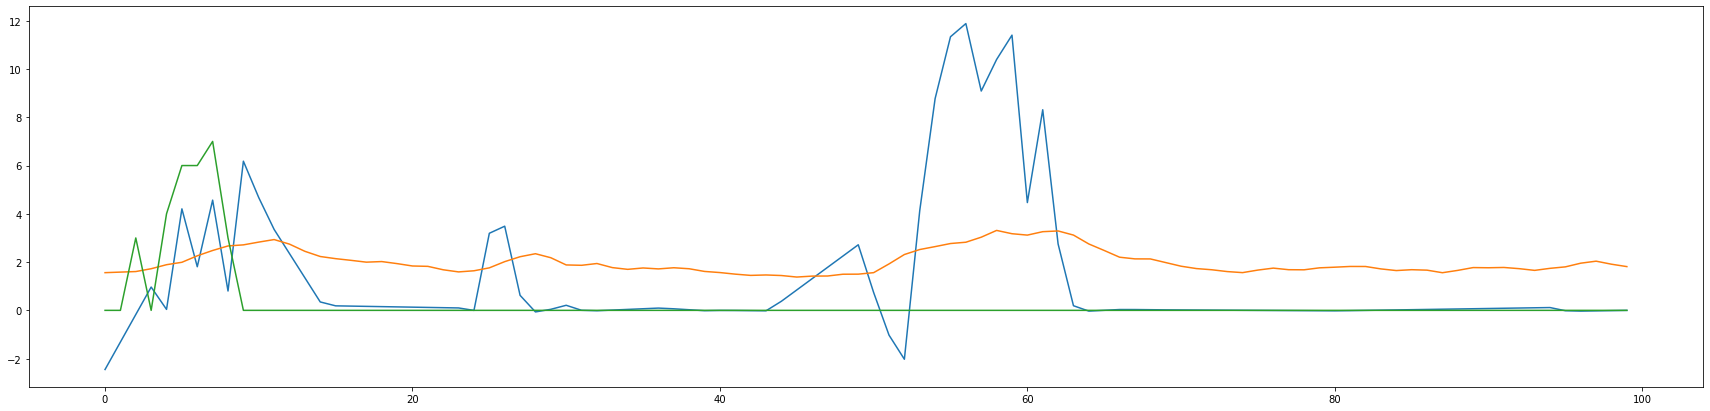

In [11]:

fig, ax = plt.subplots(figsize=(30,7))
window = np.arange(0,100)
ax.plot(time_ms[window], speed1snew[window])
ax.plot(time_ms[window],pupil1snew[window]*5)
ax.plot(time_ms[window],count_port1[window])

(6, 2975)


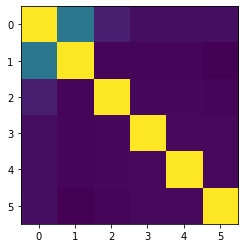

In [12]:
behaviordata = np.vstack((speed1snew, pupil1snew,count_port1, count_port2, count_port3, count_port4))
behaviordataz = zscore(behaviordata.T)
print(behaviordata.shape)

# check covariance
plt.imshow(np.cov(behaviordataz, rowvar= False))
plt.show()

[-15258.68506836   3035.36251375   4952.63322847   6203.15079344
   8436.19166021   9960.71661053   8814.5299311    8815.21511241
   8822.13030497   9923.94436417]


Text(0, 0.5, 'score')

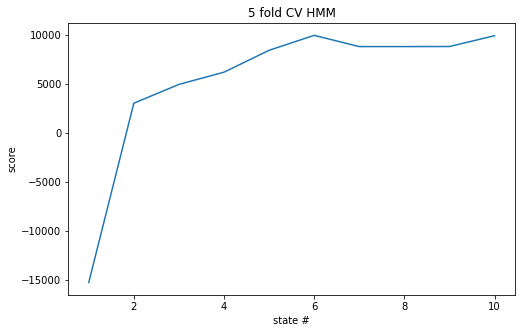

In [71]:
#@title use CV to find optimal number of Gaussians (Gaussian mixture)

from sklearn.model_selection import KFold
from sklearn.mixture import GaussianMixture
n_splits = 5
max_k = 10
kfold_iterator = KFold(n_splits)

# Initialize np array scores for all models for each split
score_all_gm = np.zeros((n_splits, max_k))

for i_split, (train_indices, val_indices) in enumerate(kfold_iterator.split(behaviordataz)):
    
  # Split up the overall training data into cross-validation training and validation sets
  X_cv_train = behaviordataz[train_indices,:]
  X_cv_val = behaviordataz[val_indices,:]

  # Fit models and evaluate
  for k in range(max_k):
    model = hmm.GaussianHMM(n_components=k+1, covariance_type="diag", n_iter=2000, tol=0.01)
    model.fit(X_cv_train)
    score_all_gm[i_split,k] = model.score(X_cv_val)

print(np.mean(score_all_gm,axis=0))
plt.figure(figsize=(8,5))
plt.title('5 fold CV HMM')
plt.plot(np.array(range(max_k))+1,(np.mean(score_all_gm,axis=0)))
plt.xlabel("state #")
plt.ylabel("score")

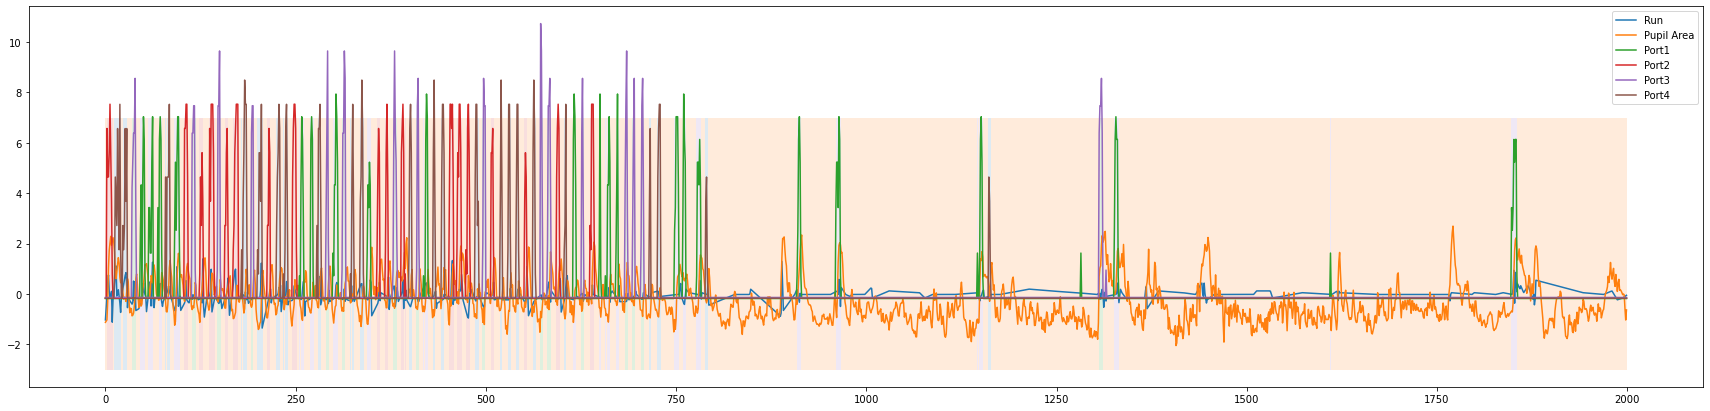

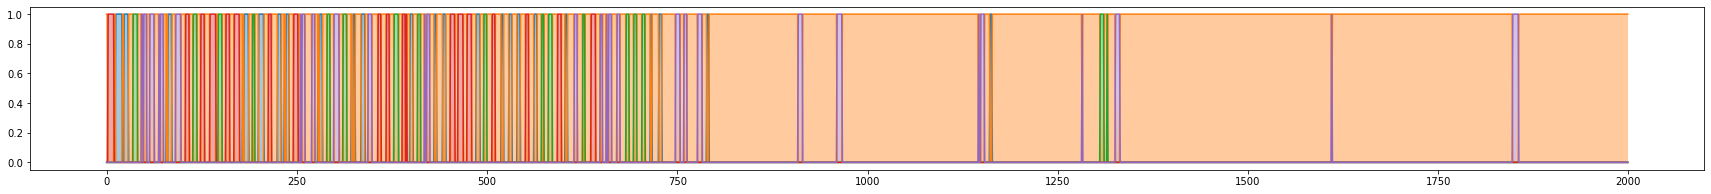

In [123]:
# Specify number of latent states
n_components =5
# Build an HMM instance and set parameters
model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=2000, tol=0.01)
model.fit(behaviordataz)

hmm_z2 = model.predict(behaviordataz[:])  
hmm_z2.shape
window = np.arange(0,2000)

fig, ax = plt.subplots(figsize=(30,7))
# plt.plot(behaviordataz[:300,:3])
# plot and add legend
plt.plot(behaviordataz[window,0],label='Run')
plt.plot(behaviordataz[window,1],label='Pupil Area')
plt.plot(behaviordataz[window,2],label='Port1')
plt.plot(behaviordataz[window,3],label='Port2')
plt.plot(behaviordataz[window,4],label='Port3')
plt.plot(behaviordataz[window,5],label='Port4')
plt.legend(loc="best")

hmm_z2_300 = hmm_z2[window]
for i in range(n_components):
  state_index = np.where(hmm_z2_300 == i)[0]
  for k in range(len(state_index)):
    rect = patches.Rectangle((state_index[k]-0.5,-3),1,10,facecolor=plt.get_cmap('tab10').colors[i], alpha = 0.15)

    ax.add_patch(rect)


plt.show()

fig, ax = plt.subplots(figsize=(30,3))
hmm_z2_prob = model.predict_proba(behaviordataz[:])
for i in range(n_components):
  state_index = np.where(hmm_z2_300 == i)[0]
  for k in range(len(state_index)):
    rect = patches.Rectangle((state_index[k]-0.5,-0),1,1,facecolor=plt.get_cmap('tab10').colors[i], alpha = 0.4)

    ax.add_patch(rect)

plt.plot(hmm_z2_prob[window,0:10])
plt.show()

In [121]:
# PCA on behavior data set (n=6) with the hidden states
PCA_model = PCA(n_components=5) # for visualization
X_PCA = PCA_model.fit_transform(behaviordataz)
print("variance explained by the first 2 PC's: %f" % 
      np.sum(PCA_model.explained_variance_ratio_[:25]))


variance explained by the first 2 PC's: 0.865914


C:\Users\Changwoo\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:794: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\Changwoo\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:796: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


Text(0.5, 0.92, 'simple 3D scatter plot')

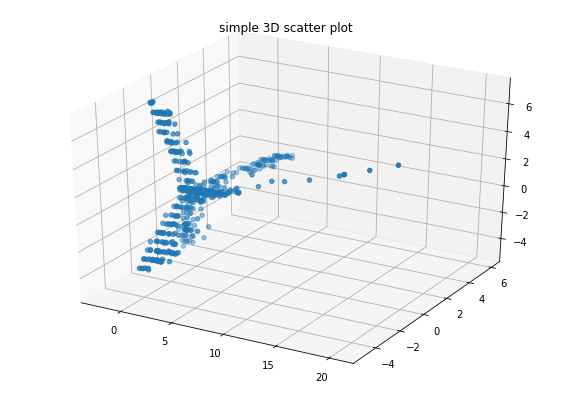

In [122]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(X_PCA[:,0],X_PCA[:,1],X_PCA[:,2], hmm_z2)
plt.title("simple 3D scatter plot")

In [146]:
#GLM

from scipy.linalg import hankel
Stim =behaviordataz[:,0] #speed
sps = behaviordataz[:,1] #pupil
ntfilt = 25
paddedStim = np.hstack((np.zeros(ntfilt-1), Stim))   # pad early bins of stimulus with zero
Xdsgn = hankel(paddedStim[:-ntfilt+1], Stim[-ntfilt:])

# (You can check for you like that this gives the same matrix as the one created above!)

# plt.clf() 
# plt.imshow(Xdsgn[:100], aspect='auto', interpolation='nearest')
# plt.xlabel('lags before spike time')
# plt.ylabel('time bin of response')
# plt.colorbar()
# plt.show()


### ======  5. Poisson GLM ====================

# Let's finally move on to the LNP / Poisson GLM!

# Package available for download from
# https://github.com/pavanramkumar/pyglmnet
from pyglmnet import GLM

### This is super-easy if we rely on built-in GLM fitting code
reg_lambda = np.logspace(np.log(1e-6), np.log(1e-8), 100, base=np.exp(1))
glm_poissonexp = GLM(distr='gaussian', verbose=False, alpha=0.05,
            max_iter=20000, learning_rate=2e-1, score_metric='pseudo_R2', eta=4.0)

glm_poissonexp.fit(Xdsgn, sps)


pGLMconst = glm_poissonexp.beta0_
pGLMfilt = glm_poissonexp.beta_
ratepred_pGLM = np.exp(pGLMconst + Xdsgn @ pGLMfilt)


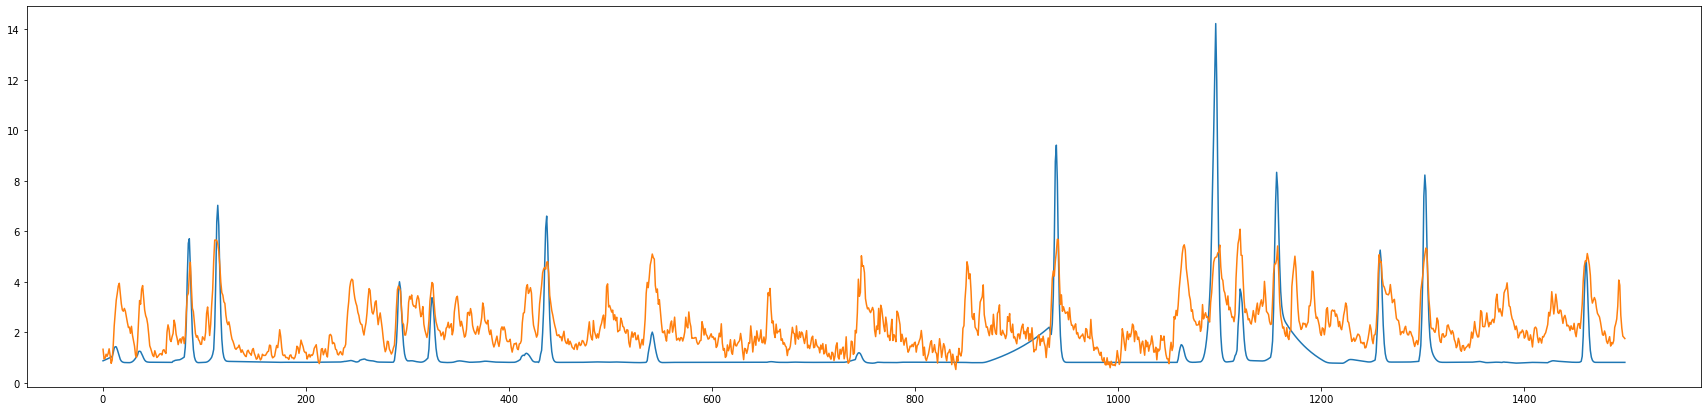

In [159]:
fig, ax = plt.subplots(figsize=(30,7))
ax.plot(ratepred_pGLM[1000:2500])
ax.plot(sps[1000:2500]+2)